**Comparación de metodos no supervisados**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor  
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Librerías importadas correctamente


**Cargar datos desde csv**

In [126]:
df_base= pd.read_csv(r'data\data_set.csv', sep = ';')
df_base.head()

,Fecha,Hora,Lectura Barométrica Actual F(Digits),Temperatura Actual T(°C),Presión Calculada P(kPa),Presión Calculada P(kPa) Corrgida,Presión Calculada (mca),Columna1,Elevación Piezométrica (msnm),Elevación Piezométrica (msnm) Corregida,Columna2
0,9/1/2023,1:30:00,"5658,5","21,8","183,61",NaN,"18,72","18,72","807,72",NaN,NaN
1,9/1/2023,1:30:01,"5658,5","21,8","183,61",NaN,"18,72","18,72","807,72",NaN,NaN
2,9/1/2023,2:30:00,"5658,2","21,7","183,56",NaN,"18,72","18,72","807,72",NaN,NaN
3,9/1/2023,3:30:00,"5658,1","21,7","183,68",NaN,"18,73","18,73","807,73",NaN,NaN
4,9/1/2023,4:30:00,"5658,3","21,7","183,45",NaN,"18,71","18,71","807,71",NaN,NaN


**Listamos los indices de las columnas para seleccionar las columnas con las que se va ha trabajar**

In [127]:
for i, col in enumerate(df_base.columns):
    print(i, col)

0 Fecha
1 Hora
2 Lectura Barométrica Actual F(Digits)
3 Temperatura Actual T(°C)
4 Presión Calculada P(kPa)
5 Presión Calculada P(kPa) Corrgida
6 Presión Calculada (mca)
7 Columna1
8 Elevación Piezométrica (msnm)
9 Elevación Piezométrica (msnm) Corregida
10 Columna2


**Definimos las columnas y  aplicamos arreglos a los datos del nuevo dataframe**

In [128]:
#Selecionamos las ccolumnas por indices
df_filt = df_base.iloc[:, [0, 1, 2, 3, 8]].copy()

# Renombramos las columnas
df_filt.columns = ['fecha', 'hora', 'digits', 'temperatura', 'elevacion']
# Convertimos la columna 'fecha' a tipo datetime
df_filt['fecha_hora'] = pd.to_datetime(df_filt['fecha'] + ' ' + df_filt['hora'],
                        format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Columnas para análisis de outliers (solo numéricas)
colum_num = ['digits', 'temperatura', 'elevacion']
# Convertimos las columnas a tipo numérico para evitar problemas con datos tipo string
for col in colum_num:
    df_filt[col] = pd.to_numeric(df_filt[col], errors='coerce')

df_filt.head()


,fecha,hora,digits,temperatura,elevacion,fecha_hora
0,9/1/2023,1:30:00,NaN,NaN,NaN,2023-01-09 01:30:00
1,9/1/2023,1:30:01,NaN,NaN,NaN,2023-01-09 01:30:01
2,9/1/2023,2:30:00,NaN,NaN,NaN,2023-01-09 02:30:00
3,9/1/2023,3:30:00,NaN,NaN,NaN,2023-01-09 03:30:00
4,9/1/2023,4:30:00,NaN,NaN,NaN,2023-01-09 04:30:00


**Exploración de datos**


In [129]:
df_num = df_filt[colum_num].copy()
print("ESTADÍSTICAS DESCRIPTIVAS\n")
print(df_num.describe().round(2))

print("\n\n🔍 VALORES FALTANTES\n")
nulos = df_num.isnull().sum()
for col, n in nulos.items():
    pct = (n / len(df_num)) * 100
    print(f"{col:20s}: {n:5d} ({pct:5.2f}%)")

ESTADÍSTICAS DESCRIPTIVAS

        digits  temperatura  elevacion
count  1162.00      1588.00     172.00
mean   5611.74        24.31     812.48
std      54.15        14.79      14.15
min    5430.00        22.00     657.00
25%    5601.00        22.00     811.00
50%    5608.00        22.00     814.00
75%    5629.00        22.00     814.00
max    6592.00       150.00     875.00


🔍 VALORES FALTANTES

digits              : 15044 (92.83%)
temperatura         : 14618 (90.20%)
elevacion           : 16034 (98.94%)


**Visualización de datos en series temporales**

Creamos gráficos de las variables para ver como estan los datos

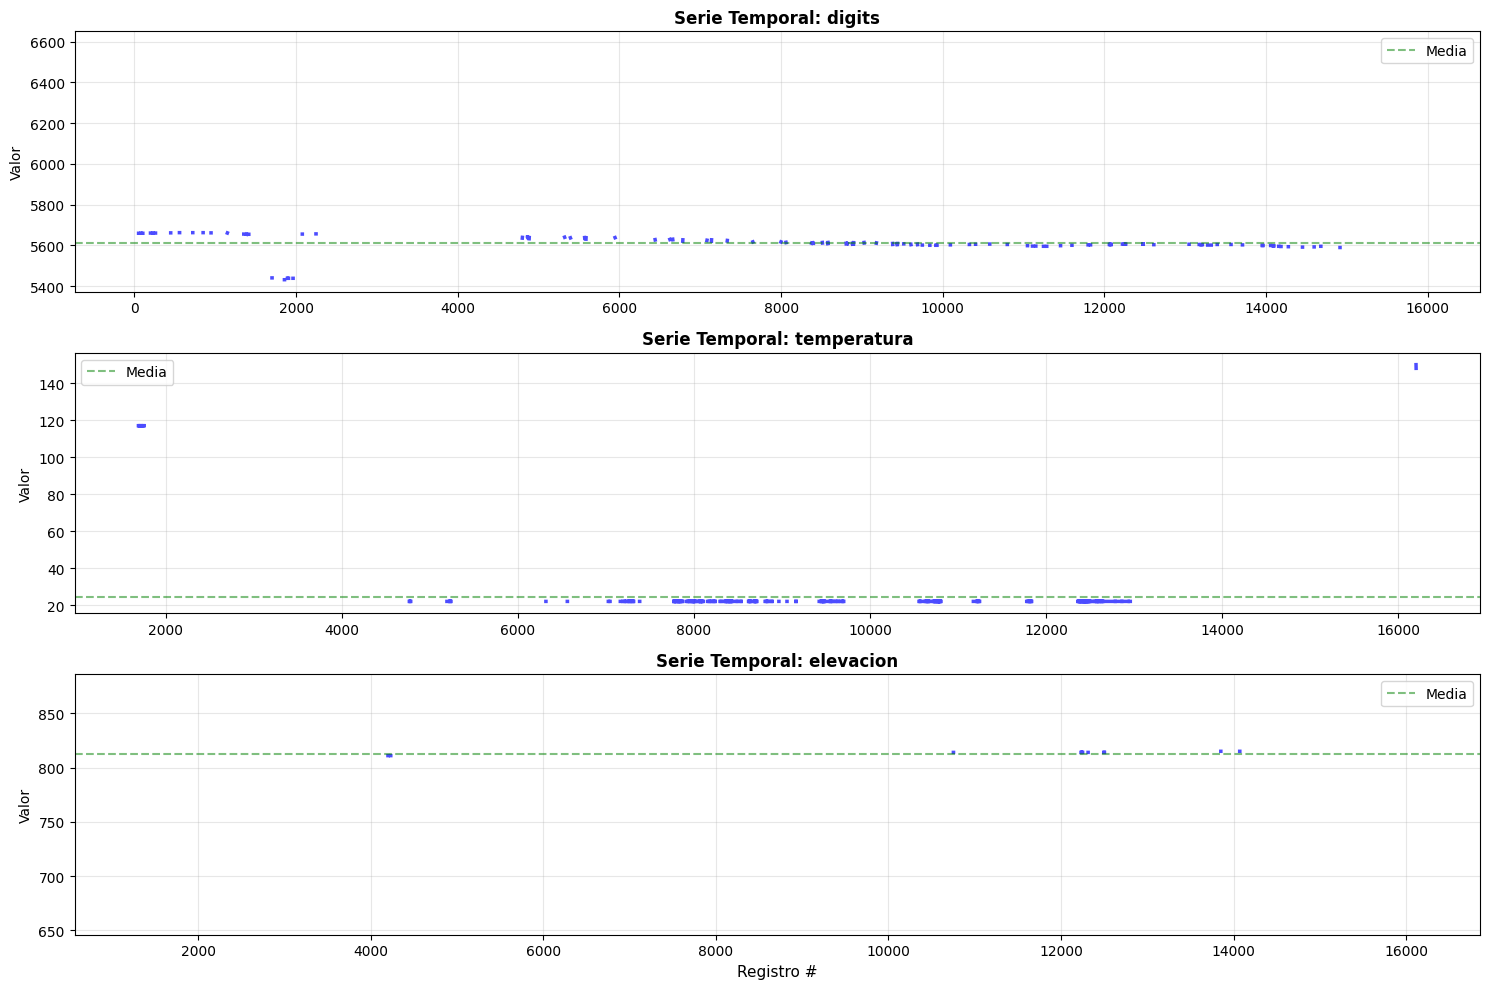

In [130]:
# Gráfico de todas las variables en el tiempo
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

variables = ['digits', 'temperatura', 'elevacion']
for i, var in enumerate(variables):
    axes[i].plot(df_num.index, df_num[var], linewidth=2.5, color='blue', alpha=0.7)
    axes[i].set_title(f'Serie Temporal: {var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valor', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # calculamos y graficamos la línea de media de los datos
    media = df_num[var].mean()
    axes[i].axhline(media, color='green', linestyle='--', alpha=0.5, label='Media')
    axes[i].legend()

axes[-1].set_xlabel('Registro #', fontsize=11)
plt.tight_layout()
plt.show()

**DETECCION DE OUTLIERS**


**Método 1: Z-Score - Método estadístico**

In [131]:
print("="*70)
print("Detecta valores que están muy lejos de la media (>3 desviaciones)")
print("="*70)

outliers_zscore = pd.DataFrame()

for col in df_num:
    mean = df_num[col].mean()
    std = df_num[col].std()
    z_scores = np.abs((df_num[col] - mean) / std)
    outliers_zscore[col] = z_scores > 3 # Umbral de 3 desviaciones estándar
    
    n_out = outliers_zscore[col].sum()
    pct = (n_out / len(df_num)) * 100
    print(f"{col:20s}: {n_out:5d} outliers ({pct:5.1f}%)")

# Total de filas con al menos un outlier
filas_con_outlier_zs = outliers_zscore.any(axis=1).sum()
print(f"\nRegistros con outliers: {filas_con_outlier_zs} ({filas_con_outlier_zs/len(df_num)*100:.1f}%)")

Detecta valores que están muy lejos de la media (>3 desviaciones)
digits              :    63 outliers (  0.4%)
temperatura         :    38 outliers (  0.2%)
elevacion           :     3 outliers (  0.0%)

Registros con outliers: 99 (0.6%)


**Método 2: IQR (Rango Intercuartílico) - Método estadístico**

In [132]:
print("="*70)
print("Usa los cuartiles para detectar valores extremos")
print("="*70)

outliers_iqr = pd.DataFrame()

for col in df_num:
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    
    outliers_iqr[col] = (df_num[col] < limite_inf) | (df_num[col] > limite_sup)
    
    n_out = outliers_iqr[col].sum()
    pct = (n_out / len(df_num)) * 100 
    print(f"{col:10s}: {n_out:5d} outliers ({pct:5.1f}%)")
    print(f"  Rango normal: [{limite_inf:.2f}, {limite_sup:.2f}]\n")

filas_con_outlier_iqr = outliers_iqr.any(axis=1).sum()
print(f"Registros con outliers: {filas_con_outlier_iqr} ({filas_con_outlier_iqr/len(df_num)*100:.1f}%)")

Usa los cuartiles para detectar valores extremos
digits    :    66 outliers (  0.4%)
  Rango normal: [5559.00, 5671.00]

temperatura:    38 outliers (  0.2%)
  Rango normal: [22.00, 22.00]

elevacion :     5 outliers (  0.0%)
  Rango normal: [806.50, 818.50]

Registros con outliers: 104 (0.6%)


**Método 3: Detección con Isolation Forest (Machine Learning)**

In [133]:
print("="*70)
print("Algoritmo de ML que 'aísla' anomalías en árboles de decisión")
print("="*70)

# Preparar datos (rellenar NaN con la media)
X = df_num.fillna(df_num.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar modelo
modelo_iso = IsolationForest(
    contamination=0.02,  # Esperamos % de outliers
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)

predicciones_iso = modelo_iso.fit_predict(X_scaled)
outliers_iso = predicciones_iso == -1

# Obtener scores (más negativo = más anómalo)
scores_iso = modelo_iso.score_samples(X_scaled)

n_outliers = sum(outliers_iso)
pct = (n_outliers / len(df_num)) * 100

print(f"Entrenamiento completado!\n")
print(f"Outliers detectados: {n_outliers} de {len(df_num)} ({pct:.1f}%)")
print(f"Score más anómalo: {scores_iso.min():.4f}")
print(f"Score más normal: {scores_iso.max():.4f}")

Algoritmo de ML que 'aísla' anomalías en árboles de decisión
Entrenamiento completado!

Outliers detectados: 316 de 16206 (1.9%)
Score más anómalo: -0.7962
Score más normal: -0.3045
Entrenamiento completado!

Outliers detectados: 316 de 16206 (1.9%)
Score más anómalo: -0.7962
Score más normal: -0.3045


**Método 4: Detección con Local Outlier Factor (Machine Learning)**

In [134]:
print("="*70)
print("Compara la densidad local de cada punto con sus vecinos")
print("="*70)

# Preparacion datos
X = df_num.fillna(df_num.mean())
X_scaled = scaler.transform(X)  

# Parámetros para entrenar el modelo
modelo_lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.02,
    n_jobs=-1
)

# Entrenamiento y predicción
predicciones_lof = modelo_lof.fit_predict(X_scaled) 
outliers_lof = predicciones_lof == -1 # Marcar outliers

# Obtener puntuación de outlier
scores_lof = modelo_lof.negative_outlier_factor_

n_outliers = sum(outliers_lof)
pct = (n_outliers / len(df_num)) * 100

radius = (scores_lof.max() - scores_lof) / (scores_lof.max() - scores_lof.min())
print(f"Entrenamiento completado!\n")
print(f"Outliers detectados: {n_outliers} de {len(df_num)} ({pct:.1f}%)")
print(f"LOF más anómalo: {scores_lof.min():.4f}")
print(f"LOF más normal: {scores_lof.max():.4f}")

Compara la densidad local de cada punto con sus vecinos
Entrenamiento completado!

Outliers detectados: 323 de 16206 (2.0%)
LOF más anómalo: -269341628762.0966
LOF más normal: -0.9077
Entrenamiento completado!

Outliers detectados: 323 de 16206 (2.0%)
LOF más anómalo: -269341628762.0966
LOF más normal: -0.9077


**Comparación de métodos**

Se resume la cantidad y porcentaje de outliera detectados por cada metodo aplicado

In [135]:
print("="*70)
print(" COMPARACIÓN DE TODOS LOS MÉTODOS")
print("="*70)

# Crear DataFrame de comparación
comparacion = pd.DataFrame({
    'zscore': outliers_zscore.any(axis=1),
    'iqr': outliers_iqr.any(axis=1),
    'isolation_forest': outliers_iso,
    'lof': outliers_lof
})

# Resumen por método
print("\n Resumen por método:\n")
resumen_data = []
for metodo in comparacion.columns:
    n = comparacion[metodo].sum()
    pct = (n / len(df_num)) * 100
    resumen_data.append({
        'Método': metodo.upper(),
        'Outliers': n,
        'Porcentaje': f"{pct:.1f}%"
    })
    
df_resumen = pd.DataFrame(resumen_data)
print(df_resumen.to_string(index=False))


 COMPARACIÓN DE TODOS LOS MÉTODOS

 Resumen por método:

          Método  Outliers Porcentaje
          ZSCORE        99       0.6%
             IQR       104       0.6%
ISOLATION_FOREST       316       1.9%
             LOF       323       2.0%


**Visualizar outliers en 2D**

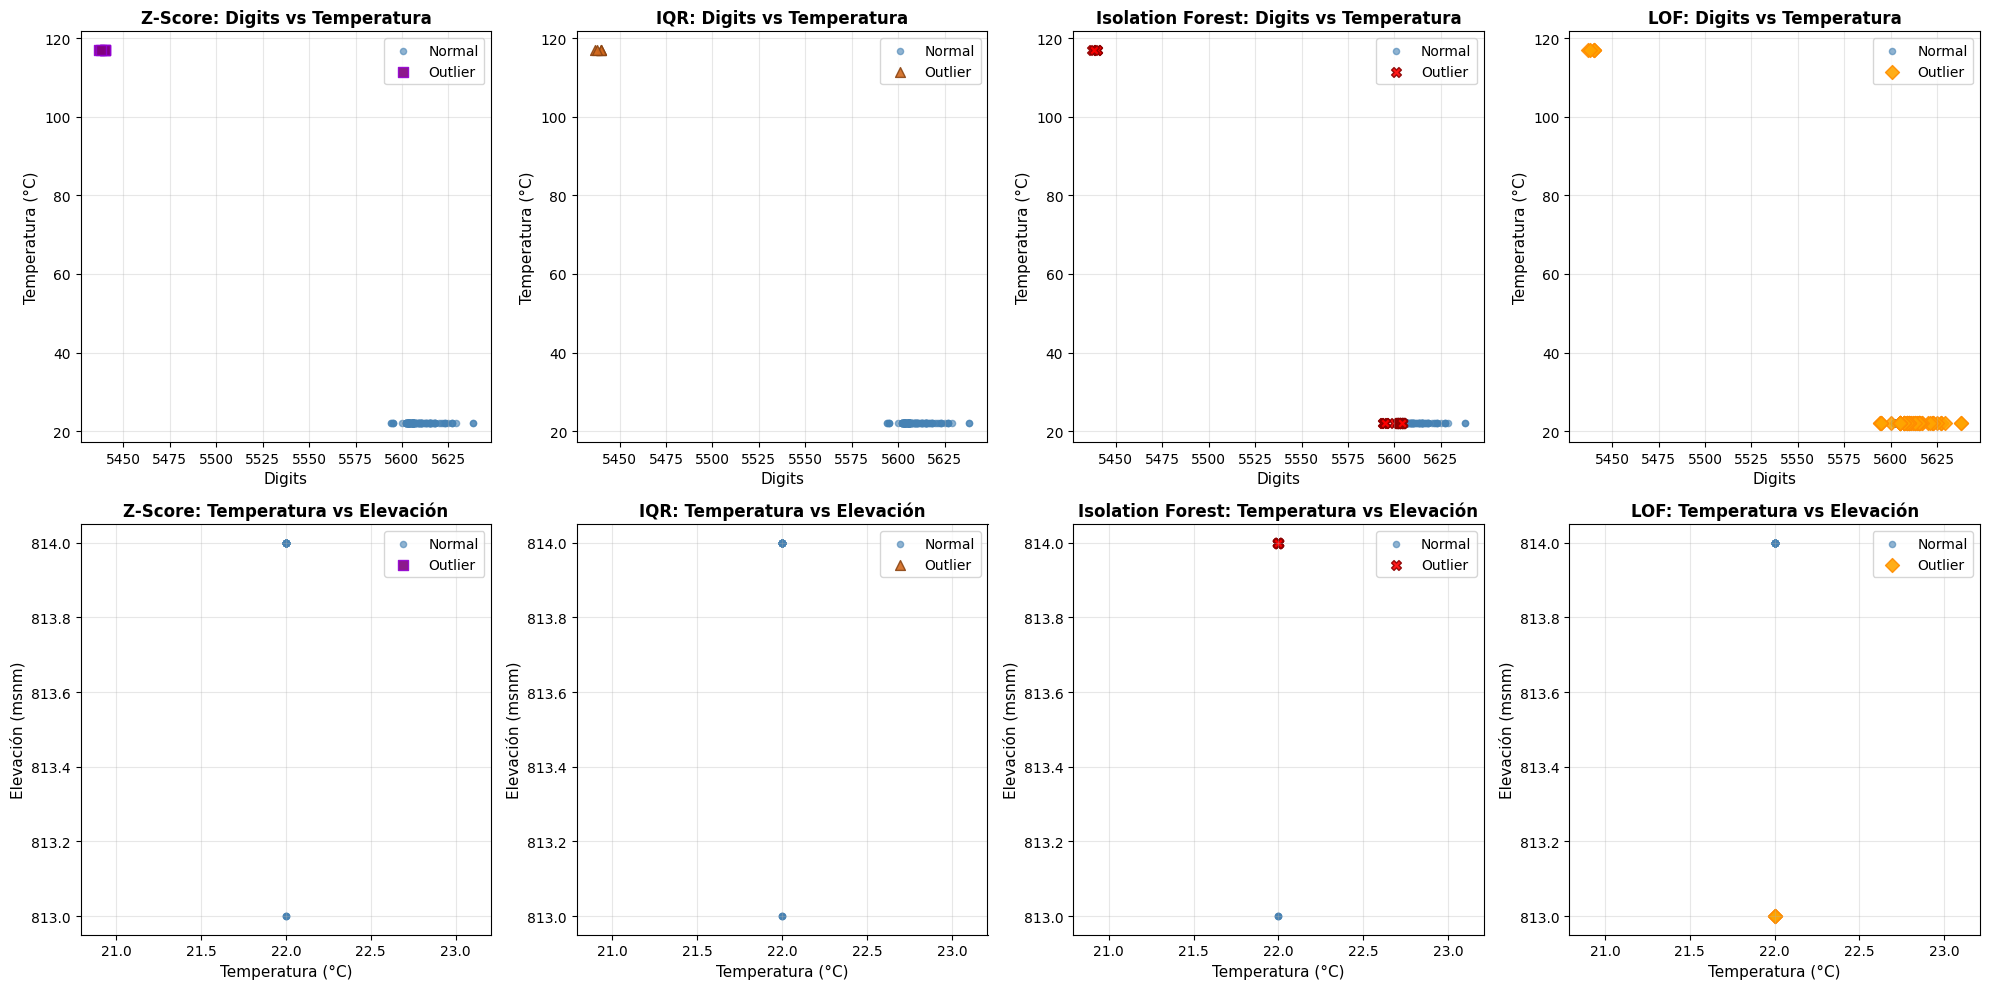

In [136]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Gráfico 1: Z-Score - digits vs temperatura
ax1 = axes[0, 0]
outliers_zscore_bool = outliers_zscore.any(axis=1)
ax1.scatter(df_num['digits'][~outliers_zscore_bool], df_num['temperatura'][~outliers_zscore_bool],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax1.scatter(df_num['digits'][outliers_zscore_bool], df_num['temperatura'][outliers_zscore_bool],
           c='purple', alpha=0.9, label='Outlier', s=50, marker='s', 
           edgecolors='darkviolet', linewidths=1)
ax1.set_xlabel('Digits', fontsize=11)
ax1.set_ylabel('Temperatura (°C)', fontsize=11)
ax1.set_title('Z-Score: Digits vs Temperatura', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: IQR - digits vs temperatura
ax2 = axes[0, 1]
outliers_iqr_bool = outliers_iqr.any(axis=1)
ax2.scatter(df_num['digits'][~outliers_iqr_bool], df_num['temperatura'][~outliers_iqr_bool],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax2.scatter(df_num['digits'][outliers_iqr_bool], df_num['temperatura'][outliers_iqr_bool],
           c='chocolate', alpha=0.9, label='Outlier', s=50, marker='^', 
           edgecolors='saddlebrown', linewidths=1)
ax2.set_xlabel('Digits', fontsize=11)
ax2.set_ylabel('Temperatura (°C)', fontsize=11)
ax2.set_title('IQR: Digits vs Temperatura', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Isolation Forest - digits vs temperatura
ax3 = axes[0, 2]
ax3.scatter(df_num['digits'][~outliers_iso], df_num['temperatura'][~outliers_iso],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax3.scatter(df_num['digits'][outliers_iso], df_num['temperatura'][outliers_iso],
           c='red', alpha=0.9, label='Outlier', s=50, marker='X', 
           edgecolors='darkred', linewidths=1)
ax3.set_xlabel('Digits', fontsize=11)
ax3.set_ylabel('Temperatura (°C)', fontsize=11)
ax3.set_title('Isolation Forest: Digits vs Temperatura', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: LOF - digits vs temperatura
ax4 = axes[0, 3]
ax4.scatter(df_num['digits'][~outliers_lof], df_num['temperatura'][~outliers_lof],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax4.scatter(df_num['digits'][outliers_lof], df_num['temperatura'][outliers_lof],
           c='orange', alpha=0.9, label='Outlier', s=50, marker='D', 
           edgecolors='darkorange', linewidths=1)
ax4.set_xlabel('Digits', fontsize=11)
ax4.set_ylabel('Temperatura (°C)', fontsize=11)
ax4.set_title('LOF: Digits vs Temperatura', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Gráfico 5: Z-Score - temperatura vs elevación
ax5 = axes[1, 0]
ax5.scatter(df_num['temperatura'][~outliers_zscore_bool], df_num['elevacion'][~outliers_zscore_bool],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax5.scatter(df_num['temperatura'][outliers_zscore_bool], df_num['elevacion'][outliers_zscore_bool],
           c='purple', alpha=0.9, label='Outlier', s=50, marker='s',
           edgecolors='darkviolet', linewidths=1)
ax5.set_xlabel('Temperatura (°C)', fontsize=11)
ax5.set_ylabel('Elevación (msnm)', fontsize=11)
ax5.set_title('Z-Score: Temperatura vs Elevación', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Gráfico 6: IQR - temperatura vs elevación
ax6 = axes[1, 1]
ax6.scatter(df_num['temperatura'][~outliers_iqr_bool], df_num['elevacion'][~outliers_iqr_bool],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax6.scatter(df_num['temperatura'][outliers_iqr_bool], df_num['elevacion'][outliers_iqr_bool],
           c='chocolate', alpha=0.9, label='Outlier', s=50, marker='^',
           edgecolors='saddlebrown', linewidths=1)
ax6.set_xlabel('Temperatura (°C)', fontsize=11)
ax6.set_ylabel('Elevación (msnm)', fontsize=11)
ax6.set_title('IQR: Temperatura vs Elevación', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Gráfico 7: Isolation Forest - temperatura vs elevación
ax7 = axes[1, 2]
ax7.scatter(df_num['temperatura'][~outliers_iso], df_num['elevacion'][~outliers_iso],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax7.scatter(df_num['temperatura'][outliers_iso], df_num['elevacion'][outliers_iso],
           c='red', alpha=0.9, label='Outlier', s=50, marker='X',
           edgecolors='darkred', linewidths=1)
ax7.set_xlabel('Temperatura (°C)', fontsize=11)
ax7.set_ylabel('Elevación (msnm)', fontsize=11)
ax7.set_title('Isolation Forest: Temperatura vs Elevación', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Gráfico 8: LOF - temperatura vs elevación
ax8 = axes[1, 3]
ax8.scatter(df_num['temperatura'][~outliers_lof], df_num['elevacion'][~outliers_lof],
           c='steelblue', alpha=0.6, label='Normal', s=20)
ax8.scatter(df_num['temperatura'][outliers_lof], df_num['elevacion'][outliers_lof],
           c='orange', alpha=0.9, label='Outlier', s=50, marker='D',
           edgecolors='darkorange', linewidths=1)
ax8.set_xlabel('Temperatura (°C)', fontsize=11)
ax8.set_ylabel('Elevación (msnm)', fontsize=11)
ax8.set_title('LOF: Temperatura vs Elevación', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Gráfica en función del tiempo**

Outliers detectados con el metodo Isolation Forest

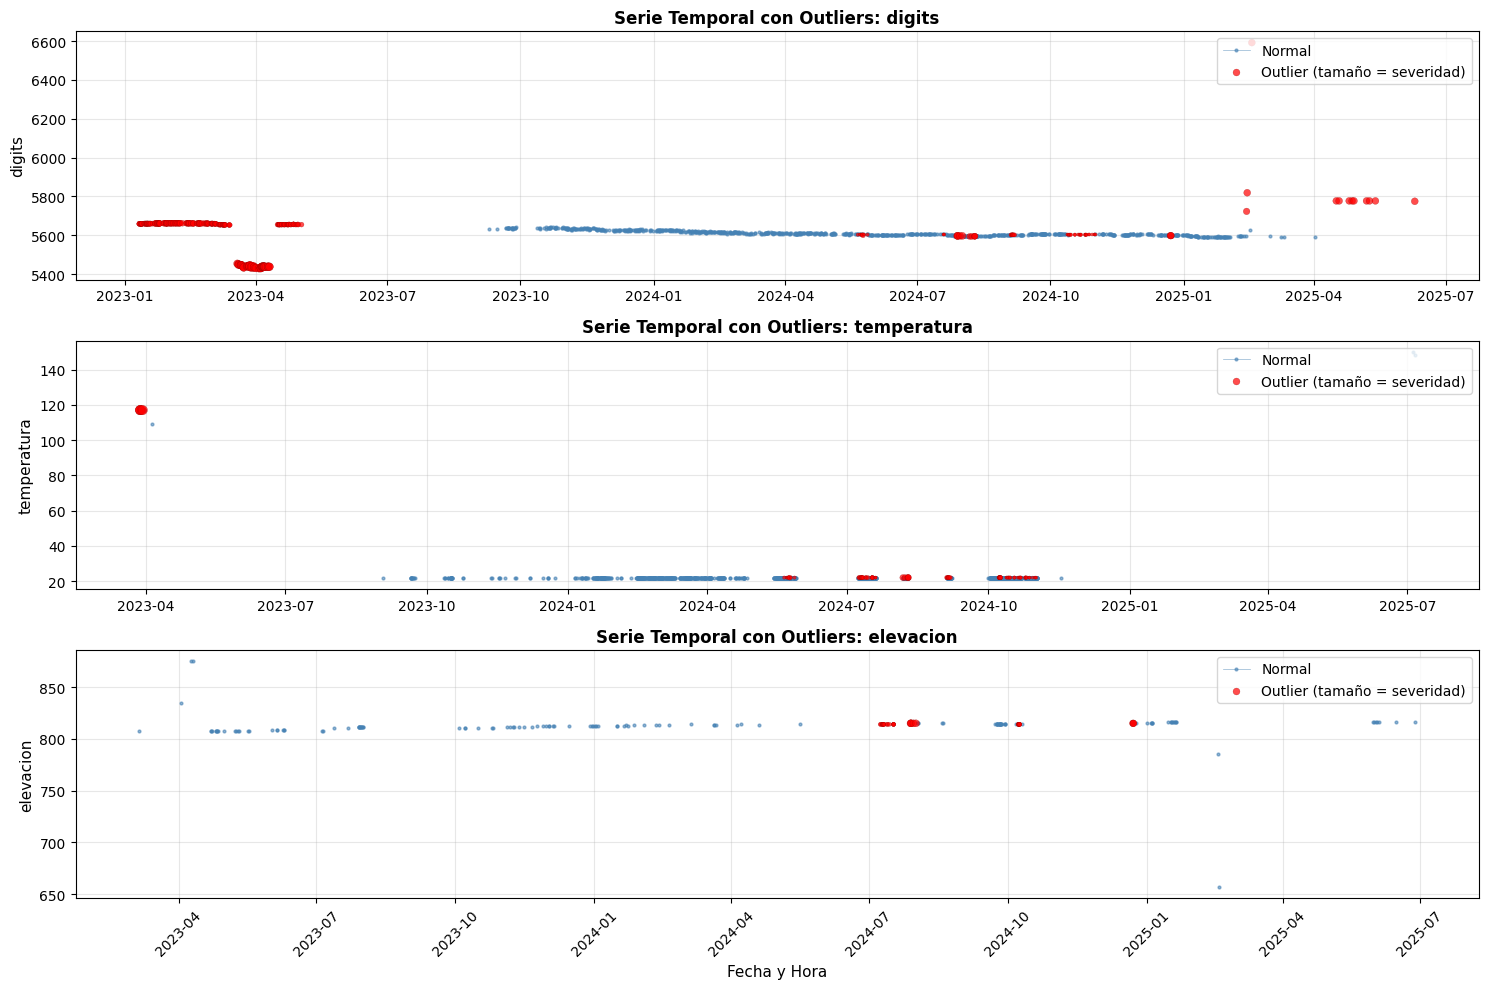

In [137]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Normalizar puntajes de outlier para tamaño de puntos
scores_abs = np.abs(scores_iso[outliers_iso])
scores_norm = (scores_abs - scores_abs.min()) / (scores_abs.max() - scores_abs.min())
sizes = 5 + scores_norm * 40 

variables = ['digits', 'temperatura', 'elevacion']
for i, var in enumerate(variables):
    ax = axes[i]
    
    # Graficar puntos normales
    ax.plot(df_filt['fecha_hora'][~outliers_iso], 
            df_filt[var][~outliers_iso], 
            'o-', color='steelblue', alpha=0.6, markersize=2, linewidth=0.5, label='Normal')
    
    # Graficar puntos outliers
    ax.scatter(df_filt['fecha_hora'][outliers_iso], 
               df_filt[var][outliers_iso], 
               s=sizes,
               c='red', 
               alpha=0.7,
               marker='o',
                edgecolors='darkred',
               linewidths=0.2,
               label='Outlier (tamaño = severidad)', 
               zorder=5)
    
    ax.set_ylabel(var, fontsize=11)
    ax.set_title(f'Serie Temporal con Outliers: {var}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha y Hora', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Gráfica en función del tiempo**

Outliers detectados con el método Local Outlier Factore LOF

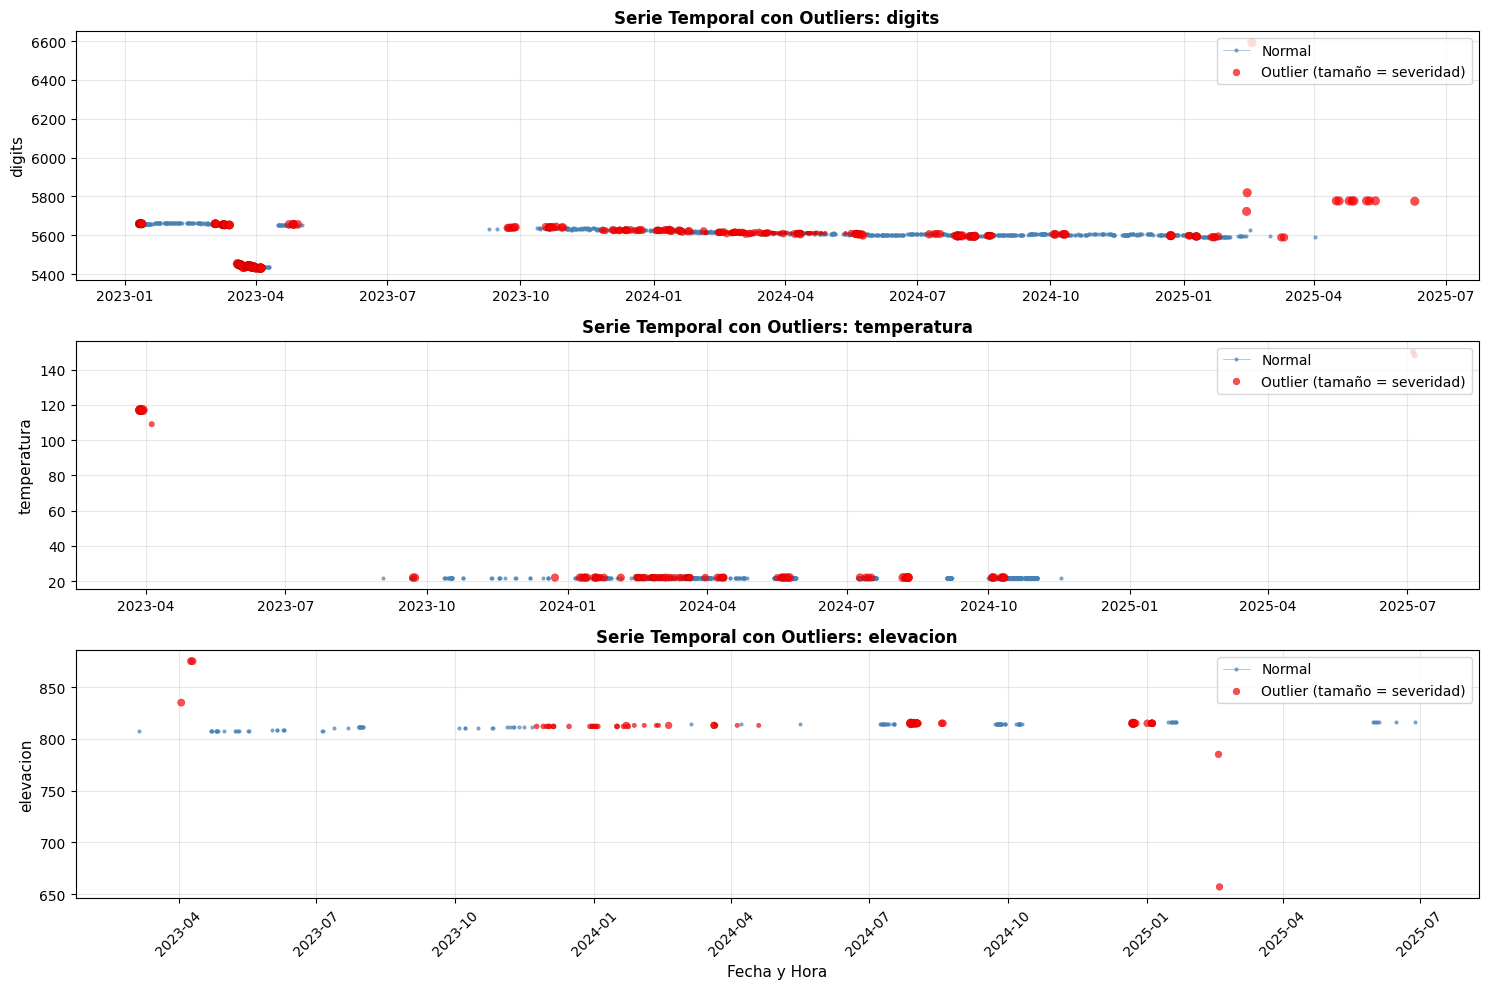

In [138]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Normalizar scores
scores_abs = np.abs(scores_iso[outliers_lof])
scores_norm = (scores_abs - scores_abs.min()) / (scores_abs.max() - scores_abs.min())
sizes = 5 + scores_norm * 40 

variables = ['digits', 'temperatura', 'elevacion']
for i, var in enumerate(variables):
    ax = axes[i]
    
    # Normalizar puntajes de outlier para tamaño de puntos
    ax.plot(df_filt['fecha_hora'][~outliers_lof], 
            df_filt[var][~outliers_lof], 
            'o-', color='steelblue', alpha=0.6, markersize=2, linewidth=0.5, label='Normal')
    
    # Graficar puntos outliers
    ax.scatter(df_filt['fecha_hora'][outliers_lof], 
               df_filt[var][outliers_lof], 
               s=sizes,
               c='red', 
               alpha=0.7,
               marker='o',
                edgecolors='darkred',
               linewidths=0.2,
               label='Outlier (tamaño = severidad)', 
               zorder=5)
    
    ax.set_ylabel(var, fontsize=11)
    ax.set_title(f'Serie Temporal con Outliers: {var}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha y Hora', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
